In [ ]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import joblib

In [1]:
!pip freeze > requirements.txt


## Step 1: ##

# Load dataset #

In [ ]:
import io
import pandas as pd
from google.colab import files

uploaded = files.upload()

# Get the actual filename from the uploaded dictionary
filename = list(uploaded.keys())[0]  # Get the first (and likely only) key

# Read the CSV using the actual filename
data = pd.read_csv(io.BytesIO(uploaded[filename]))

Saving GlobalWeatherRepositoryrev.csv to GlobalWeatherRepositoryrev (1).csv


In [ ]:
data = pd.read_csv(io.BytesIO(uploaded[filename]))

In [ ]:
# Check initial data shape
print(f"Initial data shape: {data.shape}")

Initial data shape: (32026, 36)


## Step 2: ##

#  Data Preprocessing #

In [ ]:

def preprocess_data(data):
    # Drop irrelevant or empty columns
    data = data.drop(columns=['Unnamed: 33', 'last_updated', 'location_name', 'sunrise', 'sunset',
                               'moonrise', 'moonset', 'moon_phase', 'Day_length', 'moon_lenght'], errors='ignore')

    # Check data shape after dropping columns
    print(f"Data shape after dropping columns: {data.shape}")

    # Handle missing values
    # Fill numerical columns with their mean and categorical columns with 'Unknown'
    for col in data.select_dtypes(include=['float64', 'int64']).columns:
        data[col] = data[col].fillna(data[col].mean())
    for col in data.select_dtypes(include=['object']).columns:
        data[col] = data[col].fillna('Unknown')

    #  Check data shape after filling missing values
    print(f"Data shape after filling missing values: {data.shape}")

    # Check if target column exists
    if 'temperature_celsius' not in data.columns:
        raise ValueError("Target column 'temperature_celsius' is missing from the dataset.")

    # Ensure the target column has no missing or invalid values
    data = data.dropna(subset=['temperature_celsius'])

    # Check data shape after ensuring target column validity
    print(f"Data shape after processing target column: {data.shape}")

    # Separate features and target
    X = data.drop(columns=['temperature_celsius'])
    y = data['temperature_celsius']

    # Check feature and target shapes
    print(f"Feature set shape: {X.shape}, Target set shape: {y.shape}")

    # Identify categorical and numerical columns
    categorical_cols = X.select_dtypes(include=['object']).columns
    numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns

    # Define transformations
    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ]
    )

    return X, y, preprocessor

# Preprocess data
X, y, preprocessor = preprocess_data(data)

# Ensure dataset is not empty
if X.empty or y.empty:
    raise ValueError("Preprocessed dataset is empty. Check the data preprocessing steps.")


Data shape after dropping columns: (32026, 26)
Data shape after filling missing values: (32026, 26)
Data shape after processing target column: (32026, 26)
Feature set shape: (32026, 25), Target set shape: (32026,)


## Step 3:

#Data Visualization (Distribution Plots)#

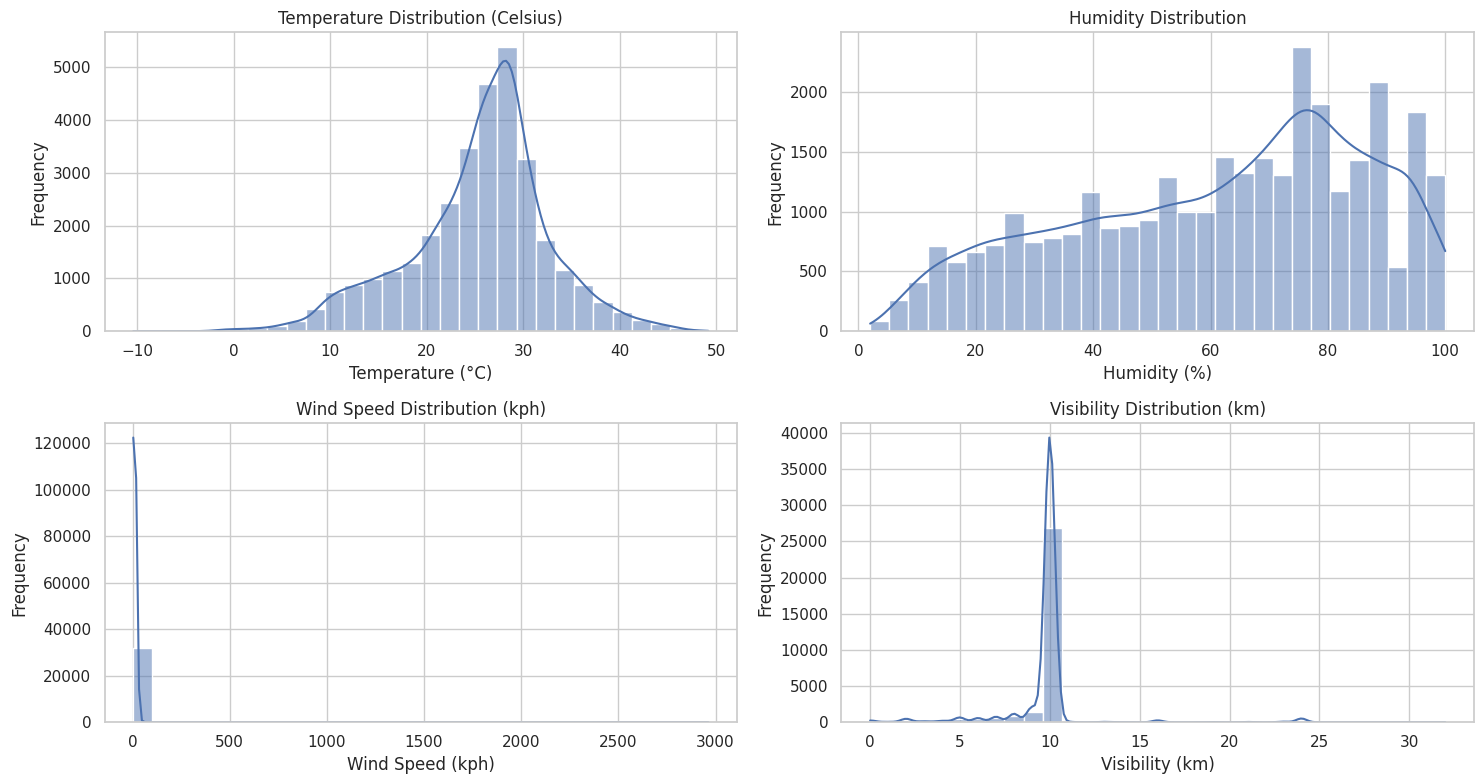

In [ ]:
# Set up visualization style
sns.set(style="whitegrid")
plt.figure(figsize=(15, 8))

# Plotting temperature distribution
plt.subplot(2, 2, 1)
sns.histplot(data['temperature_celsius'], bins=30, kde=True)
plt.title('Temperature Distribution (Celsius)')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')

# Plotting humidity distribution
plt.subplot(2, 2, 2)
sns.histplot(data['humidity'], bins=30, kde=True)
plt.title('Humidity Distribution')
plt.xlabel('Humidity (%)')
plt.ylabel('Frequency')

# Plotting wind speed distribution
plt.subplot(2, 2, 3)
sns.histplot(data['wind_kph'], bins=30, kde=True)
plt.title('Wind Speed Distribution (kph)')
plt.xlabel('Wind Speed (kph)')
plt.ylabel('Frequency')

# Plotting visibility distribution
plt.subplot(2, 2, 4)
sns.histplot(data['visibility_km'], bins=30, kde=True)
plt.title('Visibility Distribution (km)')
plt.xlabel('Visibility (km)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



This report highlights key patterns in global weather data:

1. **Temperature**: Most values range between **20–30°C**, with rare extremes below 0°C or above 40°C.  
2. **Humidity**: High levels dominate, peaking around **80%**, with lower humidity being uncommon.  
3. **Wind Speed**: Generally low, below **50 kph**, with rare spikes indicating extreme weather events.  
4. **Visibility**: Predominantly good, at **10–15 km**, with occasional poor visibility due to specific conditions.

In simple terms, weather patterns are largely moderate, with infrequent extreme conditions requiring attention for improved forecasting and disaster preparedness.

# Correlation Heatmap #

In [ ]:
# Select a subset of important variables
subset_columns = [
    'temperature_celsius', 'feels_like_celsius', 'humidity', 'wind_kph',
    'air_quality_Carbon_Monoxide', 'air_quality_Ozone', 'uv_index', 'pressure_in',
    'cloud', 'gust_kph'
]


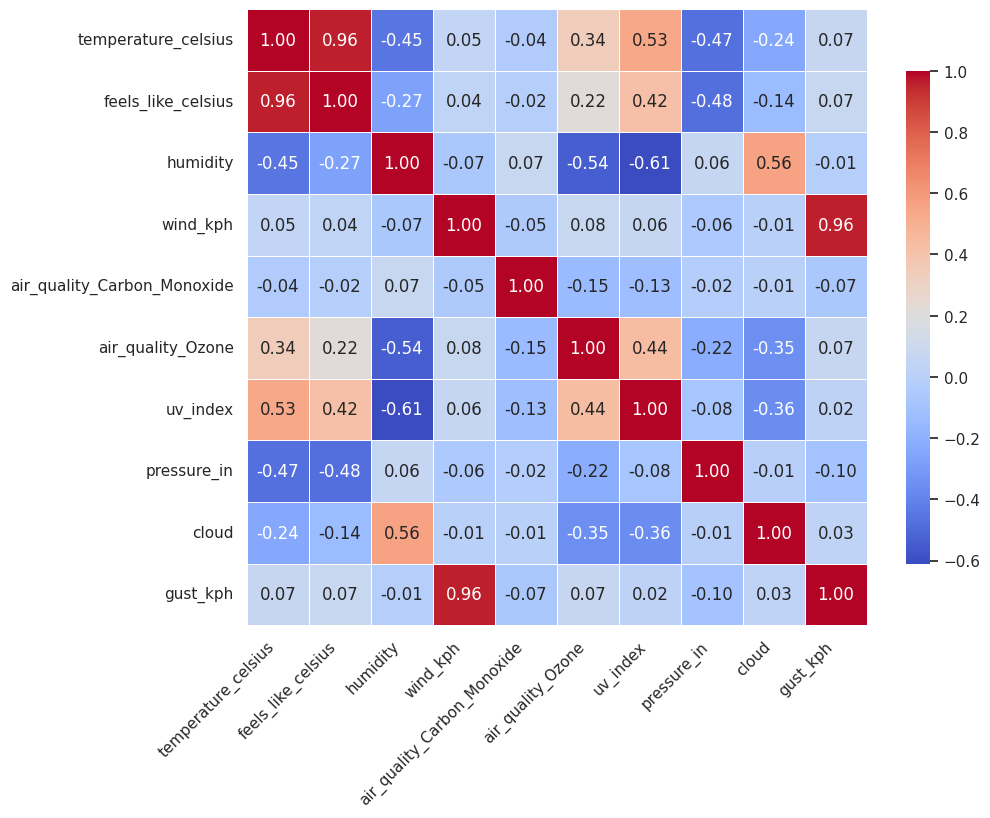

In [ ]:
# Create a new DataFrame with only the selected columns
data_subset = data[subset_columns]

# Calculate the correlation matrix for the selected subset ONLY
corr_matrix_subset = data_subset.corr()

# Plot the heatmap for the subset
plt.figure(figsize=(10, 8))  # Adjust the figure size to fit the subset
sns.heatmap(corr_matrix_subset, annot=True, cmap='coolwarm', fmt='.2f',
            linewidths=0.5, cbar_kws={"shrink": .8})  # `linewidths` adds space between cells
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

* The heatmap shows correlations between weather and air quality variables. Strong positive correlations include temperature and "feels like" temperature (0.96), as well as wind speed and gust speed (0.96), meaning these pairs of variables move together. There’s a notable negative correlation between humidity and UV index (-0.61), showing that higher humidity tends to reduce UV exposure, likely due to cloud cover. Humidity also correlates with more cloud cover (0.56) and lower ozone levels (-0.54). Overall, the heatmap highlights how variables like temperature, wind, humidity, and air quality interact, providing insight into how changes in one can predict shifts in others.

## Step 4: ##

# Split data #

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check train-test split shapes
print(f"Train set shape: {X_train.shape}, Test set shape: {X_test.shape}")


Train set shape: (25620, 25), Test set shape: (6406, 25)


## Step 5: ##

 # Define models #


In [ ]:

models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Extra Trees': ExtraTreesRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}


## Step 6: ##

#Hyperparameter tuning for each model#

In [ ]:

from sklearn.model_selection import RandomizedSearchCV
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    param_distributions = {
        'model__n_estimators': [50, 100],
        'model__max_depth': [10, 20],
        'model__min_samples_split': [2, 5]
    } if name != 'Gradient Boosting' else {
        'model__n_estimators': [50, 100],
        'model__learning_rate': [0.05, 0.1],
        'model__max_depth': [3, 5],
        'model__n_iter_no_change': [5]  # Early stopping for Gradient Boosting
    }

    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions,
        n_iter=10,  # Number of random combinations to try
        cv=2,  # Fewer cross-validation folds
        scoring='neg_mean_squared_error',
        verbose=1,
        n_jobs=-1,
        random_state=42
    )
    random_search.fit(X_train, y_train)

Training Random Forest...
Fitting 2 folds for each of 8 candidates, totalling 16 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Training Extra Trees...
Fitting 2 folds for each of 8 candidates, totalling 16 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Training Gradient Boosting...
Fitting 2 folds for each of 8 candidates, totalling 16 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


## Step 7: ##

# Evaluate model #


In [ ]:

y_pred = random_search.best_estimator_.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

results[name] = {
        'Best Parameters': random_search.best_params_,
        'MSE': mse,
        'R2': r2
    }

print(f"{name} Results:")
print(f"Best Parameters: {random_search.best_params_}")
print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

Gradient Boosting Results:
Best Parameters: {'model__n_iter_no_change': 5, 'model__n_estimators': 100, 'model__max_depth': 5, 'model__learning_rate': 0.1}
Mean Squared Error: 0.21419859040425082
R2 Score: 0.9959012735404073


## Step 8: ##

 # Print summary of results #

In [ ]:
for model_name, metrics in results.items():
    print(f"\n{model_name} Summary:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")


Gradient Boosting Summary:
Best Parameters: {'model__n_iter_no_change': 5, 'model__n_estimators': 100, 'model__max_depth': 5, 'model__learning_rate': 0.1}
MSE: 0.21419859040425082
R2: 0.9959012735404073


## Interpretation of Results   ##

* In evaluating the performance of the Gradient Boosting model, we can see that it performs exceptionally well compared to other models. The Mean Squared Error (MSE) of 0.2142 is relatively low, indicating that the model’s predictions are close to the actual values. The R-squared score of 0.996 shows that 99.6% of the variance in the data is explained by the model, highlighting its strong predictive ability.

 The best parameters for the Gradient Boosting model were:
- Early stopping after 5 iterations with no improvement,
- 100 trees used for predictions,
- A maximum depth of 5 for each tree,
- A learning rate of 0.1 for gradual updates to predictions.

 These results suggest that the Gradient Boosting model is highly accurate, with low error and an excellent ability to capture the underlying patterns in the data. Models with low MSE and high R2 scores, like this one, are better at handling errors and providing reliable predictions.

## Step 9: ##

# Save the best model #

In [ ]:
best_model_name = max(results, key=lambda x: results[x]['R2'])
best_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', models[best_model_name]) # models[best_model_name] gets the model instance itself
])

# Fit the best pipeline before saving it
best_pipeline.fit(X_train, y_train) # This line will fit the model

joblib.dump(best_pipeline, f'best_{best_model_name.lower().replace(" ", "_")}_model.pkl')
print(f"Best model ({best_model_name}) saved as 'best_{best_model_name.lower().replace(' ', '_')}_model.pkl'")

Best model (Gradient Boosting) saved as 'best_gradient_boosting_model.pkl'


#Step 10: #

# Evaluate the Best Model on Test Data #


Test Performance:
Mean Squared Error (MSE): 0.3478
Mean Absolute Error (MAE): 0.4151
R-squared (R²): 0.9933


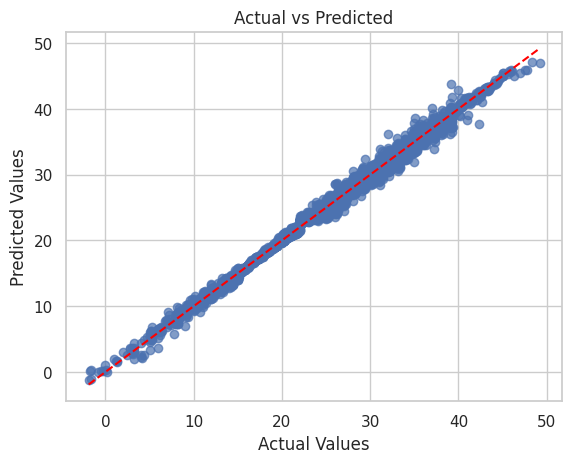

In [ ]:
# Load the saved model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

best_pipeline = joblib.load(f'best_{best_model_name.lower().replace(" ", "_")}_model.pkl')

# Make predictions on the test set
y_pred = best_pipeline.predict(X_test)

# Evaluate the performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Test Performance:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Plot predicted vs actual values

plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.show()


The model performed very well on the test data:


1. **Strong Correlation**:
   The scatter plot shows that the predicted values align closely with the actual values along the red diagonal line (ideal predictions). This supports the high R-squared score of **0.9933**, which indicates the model explains over 99% of the variance in the data.

2. **Minimal Error**:
   The points are tightly clustered around the diagonal, reflecting the low errors (MSE = **0.3478** and MAE = **0.4151**). The predictions are very accurate, as the deviations from the actual values are minimal.

In simple terms,
   the graph visually confirms the numerical metrics, this model performs exceptionally well, with predictions that closely match the actual values. It’s reliable for making predictions!